AI POWERED TASK MANAGEMENT

In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
import string

In [83]:
# Download NLTK assets (only run once). Comment the code after running
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rahul\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\rahul\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\rahul\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt_tab.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\rahul\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data]   Unzipping tokenizers\punkt_tab.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\rahul\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [69]:
df = pd.read_csv("synthetic_task_dataset.csv",index_col=0)
df.head()

,task_description,creation_date,due_date,priority,task_category,assigned_to,estimated_effort_hours,user_preferred_categories,user_past_completion_time_avg_hours,user_current_workload
task_id,,,,,,,,,,
1,Schedule interviews for Software Engineer.,2025-04-22,2025-04-28,High,HR,Noah,12,"HR, Research",9.400249,3
2,Plan team-building event for Q4.,2025-01-25,2025-01-29,High,HR,Noah,4,"HR, Research",9.400249,3
3,Optimize encryption for performance.,2025-04-05,2025-04-24,Medium,Development,Oscar,7,Development,5.266582,8
4,Update knowledge base article on troubleshooti...,2025-03-10,2025-03-22,Low,Support,Felix,7,Development,6.326326,5
5,Update employee records for address change.,2025-03-25,2025-03-30,Medium,HR,Emily,8,"HR, Marketing",6.308737,5


EDA

In [70]:
df.columns

Index(['task_description', 'creation_date', 'due_date', 'priority',
       'task_category', 'assigned_to', 'estimated_effort_hours',
       'user_preferred_categories', 'user_past_completion_time_avg_hours',
       'user_current_workload'],
      dtype='object')

In [71]:
df.drop(columns=['user_past_completion_time_avg_hours'],inplace = True)

In [72]:
df.dtypes

task_description             object
creation_date                object
due_date                     object
priority                     object
task_category                object
assigned_to                  object
estimated_effort_hours        int64
user_preferred_categories    object
user_current_workload         int64
dtype: object

In [73]:
df['creation_date'] = pd.to_datetime(df['creation_date'])
df['due_date'] = pd.to_datetime(df['due_date'])

In [74]:
df.isnull().sum()

task_description               0
creation_date                  0
due_date                     592
priority                       0
task_category                  0
assigned_to                    0
estimated_effort_hours         0
user_preferred_categories      0
user_current_workload          0
dtype: int64

In [75]:
# Create deadline-based features
df['days_until_due'] = (df['due_date'] - df['creation_date']).dt.days
df['days_until_due'] = df['days_until_due'].fillna(-1)  # -1 = No due date

# Add binary indicator
df['has_due_date'] = df['due_date'].notnull().astype(int)

In [76]:
df.head()

,task_description,creation_date,due_date,priority,task_category,assigned_to,estimated_effort_hours,user_preferred_categories,user_current_workload,days_until_due,has_due_date
task_id,,,,,,,,,,,
1,Schedule interviews for Software Engineer.,2025-04-22,2025-04-28,High,HR,Noah,12,"HR, Research",3,6.0,1
2,Plan team-building event for Q4.,2025-01-25,2025-01-29,High,HR,Noah,4,"HR, Research",3,4.0,1
3,Optimize encryption for performance.,2025-04-05,2025-04-24,Medium,Development,Oscar,7,Development,8,19.0,1
4,Update knowledge base article on troubleshooti...,2025-03-10,2025-03-22,Low,Support,Felix,7,Development,5,12.0,1
5,Update employee records for address change.,2025-03-25,2025-03-30,Medium,HR,Emily,8,"HR, Marketing",5,5.0,1


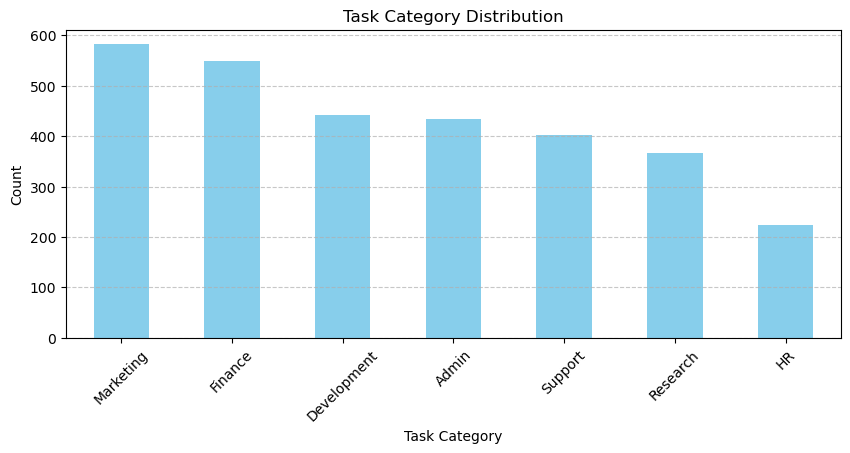

In [77]:
# Task Category Count Plot
df['task_category'].value_counts().plot(kind='bar', figsize=(10, 4), color='skyblue', title='Task Category Distribution')
plt.xlabel('Task Category')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

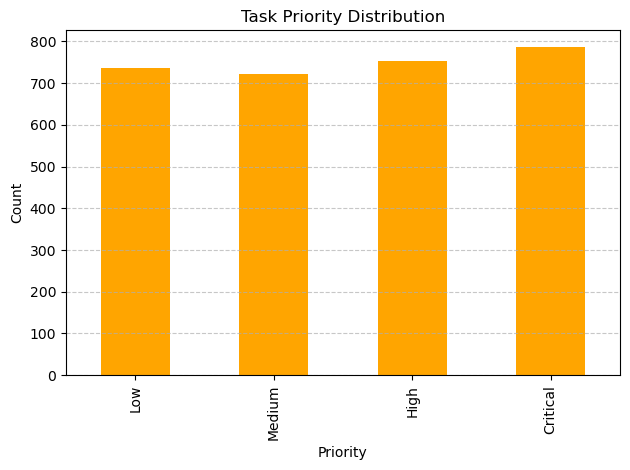

In [78]:

# Priority Count Plot
df['priority'].value_counts().loc[['Low', 'Medium', 'High', 'Critical']].plot(kind='bar', color='orange', title='Task Priority Distribution')
plt.xlabel('Priority')
plt.ylabel('Count')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

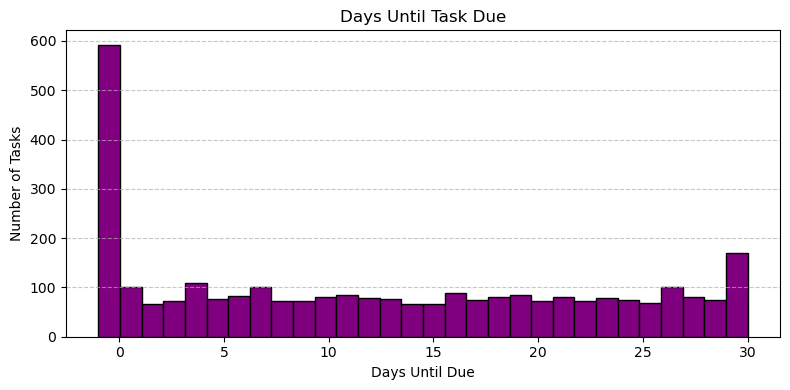

In [79]:
# Days Until Due Histogram
plt.figure(figsize=(8, 4))
plt.hist(df['days_until_due'], bins=30, color='purple', edgecolor='black')
plt.title('Days Until Task Due')
plt.xlabel('Days Until Due')
plt.ylabel('Number of Tasks')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

NLP Preprocessing

In [80]:
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

def preprocess_text(text):
    # Lowercase
    text = text.lower()
    
    # Remove punctuation & numbers
    text = re.sub(r'\d+', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    # Tokenize
    tokens = word_tokenize(text)
    
    # Remove stopwords and apply stemming
    cleaned = [stemmer.stem(word) for word in tokens if word not in stop_words]
    
    return " ".join(cleaned)



In [84]:
df['clean_description'] = df['task_description'].apply(preprocess_text)
df[['task_description', 'clean_description']].head()


,task_description,clean_description
task_id,,
1,Schedule interviews for Software Engineer.,schedul interview softwar engin
2,Plan team-building event for Q4.,plan teambuild event q
3,Optimize encryption for performance.,optim encrypt perform
4,Update knowledge base article on troubleshooti...,updat knowledg base articl troubleshoot guid
5,Update employee records for address change.,updat employe record address chang
